#### Similar to the `compare lig_res_interactions_by_type`, the goal here is compare interactions between simulations, only here is about specific residues, not specific interactions

This used to be a same part of that script when it was a sandbox script, but I figured it would be best that this is alone now


This is going to be used to measure how interactions are between conditions (eg showing that crystal sims don't have very different fingerprints, whereas EM does)

In [2]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import prolif as plf
import MDAnalysis as mda
import pandas as pd
import seaborn as sns

sys.path.append('../')
import src.analysis_functions as analysis_functions
import src.simulation_metadata as sims
from src.figure_parameters import figure_rc_params
import matplotlib as mpl

In [32]:
crystal_or_em = 'em_binding_fp'

if crystal_or_em == 'crystal_binding_fp':
    sim_list = [sims.PfHT_MMV_crystal, 
                sims.PfHT_MMV8_crystal, 
                sims.W412A_MMV_crystal,
                sims.GLUT3_MMV_crystal
                ]
elif crystal_or_em == 'em_binding_fp':
    sim_list = [sims.PfHT_MMV12, 
                sims.PfHT_MMV8, 
                sims.W412A_MMV12,
                sims.GLUT1_MMV12
                ]

#sim_list = [sims.PfHT_3361_em, sims.PfHT_3361_crystal]

color_l = [sim.color for sim in sim_list]

all_unis, all_lens = analysis_functions.load_unis(
    sim_list= sim_list
)


In [33]:
all_fp_dfs = {}
skip = 1

for sim in sim_list:
    temp_fp_dfs = []
    for n, rep_fp in enumerate(all_unis[sim.name]):
        df = analysis_functions.get_fp_dataframe(
            u=rep_fp,
            skip=skip,
            run_calc=False,
            filename=f"{sim.name}.replica_{n+1}.skip{skip}",
        )
        temp_fp_dfs.append(df)
    all_fp_dfs[sim.name] = temp_fp_dfs


# d425 vs h416
i apologize for this. I am so tired and desperate to just plot anything 

In [35]:
with mpl.rc_context(figure_rc_params):

    fig, ax = plt.subplots(1,3, figsize=(10,3))
    ax=np.ravel(ax)
    for rep in np.arange(0,3):
        u = all_unis[sims.PfHT_MMV12.name][rep] 

        import MDAnalysis.analysis.distances as d

        h416 = u.select_atoms('resname HSD and resid 395 and not backbone')
        d425 = u.select_atoms('resname ASP and resid 404 and not backbone')
        mmv = u.select_atoms('resname MMV and name O6 H24')
        dist_h416 = []
        #dist_m150 = []
        dist_d425 = []
        for ts in u.trajectory:
            dist_h416.append(np.min(d.distance_array(h416.positions, mmv.positions)))
         #   dist_m150.append(np.min(d.distance_array(m150.positions, mmv.positions)))
            dist_d425.append(np.min(d.distance_array(d425.positions, mmv.positions)))

        dist_h416 = np.array(dist_h416)
        #dist_m150 = np.array(dist_m150)
        dist_d425 = np.array(dist_d425)


        cutoff=3
        dist_h416[dist_h416>cutoff] = 0
        dist_h416[dist_h416!=0] = 1

        dist_d425[dist_d425>cutoff] = 0
        dist_d425[dist_d425!=0] = 1

        time = np.arange(0, len(dist_d425))
        width =0.18
        align = 'center'
        colors = ['#B1CDA6', '#D1D1D1', '#62B6CB', '#FFE381']
        ax[rep].bar(0.2, len(np.where(dist_d425 + dist_h416 == 2)[0])/len(time), align=align, width=width, color=colors[0])
        ax[rep].bar(0.4, len(np.where(dist_d425 + dist_h416 == 0)[0])/len(time), align=align, width=width,color=colors[1])
        ax[rep].bar(0.6, len(np.where(dist_d425 - dist_h416 == 1)[0])/len(time), align=align,width=width,color=colors[2])
        ax[rep].bar(0.8, len(np.where(dist_d425 - dist_h416 == -1)[0])/len(time), align=align, width=width,color=colors[3])

        for bars in ax[rep].containers:
            ax[rep].bar_label(bars, np.round(bars.datavalues*100, 0))

        ax[rep].set_xticks([0.2,0.4,0.6,0.8],['Both','Neither','D425','H416'])
        ax[rep].set_title(f'Replica {rep+1}')

        ax[rep].set_xlim(0.1,0.9)
        ax[rep].set_ylim(0,1)
        ax[rep].set_yticks([0,0.25,0.5,0.75,1], ['0%', '25%', '50%', '75%', '100%'])

    plt.tight_layout()

plt.savefig('../../../images_paper/simulations/D425_vs_H416.svg')


# Pi stacking to W412

In [6]:
df = all_fp_dfs[sims.PfHT_MMV12.name][0]
rep1 = np.array(df['TRP391']['PiStacking'], dtype=int)

df = all_fp_dfs[sims.PfHT_MMV12.name][1]
rep2 = np.array(df['TRP391']['PiStacking'], dtype=int)

df = all_fp_dfs[sims.PfHT_MMV12.name][2]
rep3 = np.array(df['TRP391']['PiStacking'], dtype=int)

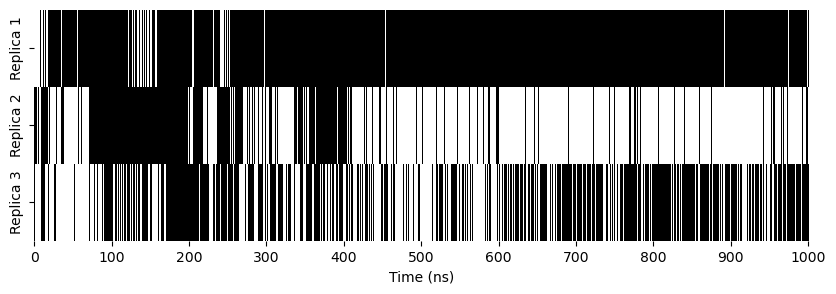

In [7]:
f,ax = plt.subplots(1,1, figsize=(10,3))
test = [rep1,rep2,rep3]
test = np.array(test)
g = sns.heatmap(test,cbar=False, cmap=['white', 'black'], xticklabels=100)
ax.set_yticks([0.5,1.5,2.5], ['Replica 1','Replica 2','Replica 3'])
ax.set_xlabel('Time (ns)')
plt.savefig('../../../images_paper/simulations/W412_pi_stacking.png', bbox_inches='tight')
plt.show()

In [8]:
np.sum(rep3)

585

# Hbonding between Q169 and T173 (PfHT) vs Q161 and V165 (GLUT1)

Just show RMSD for now

In [9]:
from MDAnalysis.analysis.rms import RMSD


In [10]:
crystal_or_em = 'em_binding_fp'

if crystal_or_em == 'crystal_binding_fp':
    sim_list = [sims.PfHT_MMV_crystal, 
                sims.PfHT_MMV8_crystal, 
                sims.W412A_MMV_crystal,
                sims.GLUT3_MMV_crystal
                ]
elif crystal_or_em == 'em_binding_fp':
    sim_list = [sims.PfHT_MMV12, 
                sims.PfHT_MMV8, 
                sims.W412A_MMV12,
                sims.GLUT1_MMV12
                ]

#sim_list = [sims.PfHT_3361_em, sims.PfHT_3361_crystal]

color_l = [sim.color for sim in sim_list]

all_unis, all_lens = analysis_functions.load_unis(
    sim_list= sim_list
)

for rep in np.arange(0,3):
    u = all_unis[sims.PfHT_MMV12.name][rep]
    u.add_TopologyAttr('resid', list(range(22, len(u.residues)+22)))


for rep in np.arange(0,3):
    u = all_unis[sims.GLUT1_MMV12.name][rep]
    u.add_TopologyAttr('resid', list(range(8, len(u.residues)+8)))

again, so sorry. Desparation

In [30]:
with mpl.rc_context(figure_rc_params):

    fig,ax = plt.subplots(2,2,figsize=(10,3),sharex=True)
    ax = np.ravel(ax)

    ref = mda.Universe(sims.PfHT_MMV12.ref_path)
    color_l = ['#618c03', '#D1FA7B', '#2C5900']

    for rep in np.arange(0,3):
        u = all_unis[sims.PfHT_MMV12.name][rep]

        R = RMSD(
            u,
            ref,
            select='backbone',
            groupselections=['resid 169 and resname GLN', 'resname MMV'],
        )
        print(u.select_atoms('resid 169').residues)
        R.run()
        rmsd = R.results.rmsd.T

        ax[0].plot(rmsd[3], color = color_l[rep])
        ax[2].plot(rmsd[4], color = color_l[rep])
        ax[0].set_xlim(0,1000)
        ax[0].set_ylim(0,5)
        ax[0].set_title('RMSD Q169')
        ax[2].set_title('RMSD MMV')
        ax[2].set_ylim(0, 15)



    ref = mda.Universe(sims.GLUT1_MMV12.ref_path)
    color_l = ['#878787', '#BABABA', '#CFCFCF']
    for rep in np.arange(0,3):
        u = all_unis[sims.GLUT1_MMV12.name][rep]
    
        R = RMSD(
            u,
            ref,
            select='backbone',
            groupselections=['resid 161 and resname GLN', 'resname MMV'],
        )
        print(u.select_atoms('resid 161').residues)
        R.run()
        rmsd = R.results.rmsd.T

        ax[1].plot(rmsd[3], color = color_l[rep])
        ax[1].set_ylim(0,5)
        ax[1].set_title('RMSD Q161')
        ax[3].plot(rmsd[4], color = color_l[rep])
        ax[3].set_title('RMSD MMV')
        ax[3].set_ylim(0,15)
        

    ax[2].set_xlabel('Time (ns)')
    ax[3].set_xlabel('Time (ns)')
    ax[0].set_ylabel('RMSD (Å)')
    ax[2].set_ylabel('RMSD (Å)')
    plt.tight_layout()
    plt.savefig('../../../images_paper/simulations/RMSD_q169_v_q161.svg', bbox_inches='tight')



<ResidueGroup [<Residue GLN, 169>]>
<ResidueGroup [<Residue GLN, 169>]>
<ResidueGroup [<Residue GLN, 169>]>
<ResidueGroup [<Residue GLN, 161>]>
<ResidueGroup [<Residue GLN, 161>]>
<ResidueGroup [<Residue GLN, 161>]>


In [41]:
u.select_atoms('resid 7').resnames

array(['LEU', 'LEU', 'LEU', 'LEU', 'LEU', 'LEU', 'LEU', 'LEU', 'LEU',
       'LEU', 'LEU', 'LEU', 'LEU', 'LEU', 'LEU', 'LEU', 'LEU', 'LEU',
       'LEU', 'LEU', 'LEU'], dtype=object)

In [37]:
ref.select_atoms('resid 8').resnames

array(['LEU', 'LEU', 'LEU', 'LEU', 'LEU', 'LEU', 'LEU', 'LEU', 'LEU',
       'LEU', 'LEU', 'LEU', 'LEU', 'LEU', 'LEU', 'LEU', 'LEU', 'LEU',
       'LEU', 'LEU', 'LEU'], dtype=object)

In [106]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

In [138]:
u = all_unis[sims.PfHT_MMV12.name][2]
u.select_atoms('resid 152 and resname THR')

<AtomGroup with 14 atoms>

In [139]:
hbonds = HBA(
  universe=u,
  between=['resid 148 and resname GLN', 'resid 152 and resname THR']
  )
hbonds.run()

/home/semccomas/anaconda3/envs/prolif/lib/python3.9/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:761: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, None, and Acceptor, (resname ALA and name O) or (resname ARG and name NE) or (resname ARG and name NH1) or (resname ARG and name NH2) or (resname ARG and name O) or (resname ASN and name ND2) or (resname ASN and name O) or (resname ASN and name OD1) or (resname ASP and name O) or (resname ASP and name OD1) or (resname ASP and name OD2) or (resname CYS and name O) or (resname GLN and name NE2) or (resname GLN and name O) or (resname GLN and name OE1) or (resname GLU and name O) or (resname GLU and name OE1) or (resname GLU and name OE2) or (resname GLY and name O) or (resname HSD and name NE2) or (resname HSD and name O) or (resname ILE and name O) or (resname LEU and name O) or (resname LYS and name O) or (resname MET and name O) or (resname MET and name OT1) or (resname MET and name OT2) o

In [146]:
test = []
f,ax = plt.subplots(1,1, figsize=(10,3))
test.append(r1)
test.append(r2)
test.append(hbonds.count_by_time())
#test = np.array(test)

#
# g = sns.heatmap(test,cbar=True, cmap=['white','grey', 'black'], xticklabels=100)
test
#plt.show()

[array([0, 0, 1, ..., 2, 1, 2]),
 array([1, 0, 2, ..., 1, 1, 1]),
 array([1, 0, 1, ..., 2, 2, 1])]

In [128]:
r1 = hbonds.count_by_time()

In [137]:
r2 = hbonds.count_by_time()